# Diagnostics: Bias vs. Variance

In [1]:
# import key libraries (remember to pip install numpy etc. first)
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Loading and Visualizing Data

In [2]:
# Load Training Data
print('Loading and Visualizing Data ...')

# import csv data
PATH="./data/"
DATA="ex5data1.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y
X = mat['X']
y = mat['y']
Xtest = mat['Xtest']
Xval = mat['Xval']
ytest = mat['ytest']
yval = mat['yval']

Loading and Visualizing Data ...


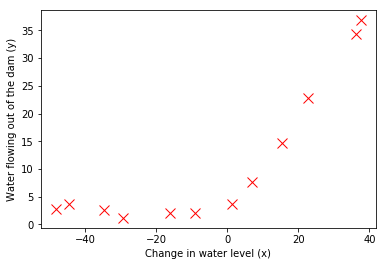

In [3]:
# m = Number of examples
m = X.shape[0]

# Plot training data
plt.plot(X, y, 'rx', markersize=10, linewidth=1.5);
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');

plt.show()

## Part 2: Regularized Linear Regression Cost

In [4]:
def linear_reg_cost_function(X, y, theta, Lambda):
#LINEARREGCOSTFUNCTION Compute cost and gradient for regularized linear
#regression with multiple variables
#   [J, grad] = LINEARREGCOSTFUNCTION(X, y, theta, lambda) computes the
#   cost of using theta as the parameter for linear regression to fit the
#   data points in X and y. Returns the cost in J and the gradient in grad

    # Initialize some useful values
    m = y.size # number of training examples

    hypothesis = X@theta
    cost = (hypothesis - y)**2
    
    J_nonreg = 1/(2*m)*np.sum(cost)
    
    regularization = 1/(2*m)*sum(Lambda * theta[1:,:]**2) # note need to drop first term
    
    J = J_nonreg + regularization

    #print(f'linear_reg_cost_function theta: theta {theta.shape} \n {theta} ')
    
    grad_nonreg = (np.sum((hypothesis - y)*X,axis=0)/m)
    grad_nonreg = grad_nonreg.reshape((1,grad_nonreg.size)).T
    #print(f'linear_reg_cost_function theta: grad nonreg {grad_nonreg.shape} \n {grad_nonreg} ')
    # [0; lambda.*(theta(2:end,:))]./m;
    grad_regularization = np.r_[np.zeros((1,1)), Lambda*(theta[1:,:])]/m
    #print(f'linear_reg_cost_function theta: grad reg {grad_regularization.shape} \n {grad_regularization} ')
    
    grad = grad_nonreg + grad_regularization
    #print(f'linear_reg_cost_function theta: grad {grad.shape} \n {grad} ')

    return J.ravel(), grad.ravel()


In [5]:
theta = np.matrix('[1 ; 1]').A
print(theta.shape)
J, g = linear_reg_cost_function(np.c_[np.ones((m, 1)), X], y, theta, 1)
print(f'Cost at theta = {theta.T}: {J[0]:.6f} \n(this value should be about 303.993192)')


(2, 1)
Cost at theta = [[1 1]]: 303.993192 
(this value should be about 303.993192)


## Part 3: Regularized Linear Regression Gradient

In [6]:
theta = np.matrix('[1 ; 1]').A
J, grad = linear_reg_cost_function(np.c_[np.ones((m, 1)), X], y, theta, 1)

print(f'Gradient at theta = [1 ; 1]:  {grad} \n {grad[0]:.6f}; {grad[1]:.6f} \n(this value should be about -15.303016; 598.250744)')

Gradient at theta = [1 ; 1]:  [ -15.30301567  598.25074417] 
 -15.303016; 598.250744 
(this value should be about -15.303016; 598.250744)


## Part 4: Train Linear Regression
Once you have implemented the cost and gradient correctly, the <br/>
trainLinearReg function will use your cost function to train <br/>
regularized linear regression. <br/>
<br/>
Write Up Note: The data is non-linear, so this will not give a great fit. <br/>
<br/>
Train linear regression with lambda = 0

In [7]:
import scipy.optimize as opt 
import sys

callb_count = 0
callb_disp = True

def callb(x):
    global callb_count
    callb_count += 1
    if callb_disp:
        sys.stdout.write(f'{callb_count}, ')

def costf(theta, X, y, Lambda):
    theta = theta.reshape((theta.size,1))
    return linear_reg_cost_function(X, y, theta, Lambda)[0]
def gradf(theta, X, y, Lambda):
    theta = theta.reshape((theta.size,1))
    #print(f'gradf \n theta {theta}')
    ret = linear_reg_cost_function(X, y, theta, Lambda)[1]
    #print(f'gradf \n ret {ret}')
    return ret

In [8]:
def train_linear_reg(X, y, Lambda):
#TRAINLINEARREG Trains linear regression given a dataset (X, y) and a
#regularization parameter lambda
#   [theta] = TRAINLINEARREG (X, y, lambda) trains linear regression using
#   the dataset (X, y) and regularization parameter lambda. Returns the
#   trained parameters theta.

    # Initialize Theta
    initial_theta = np.zeros((X.shape[1], 1)) 
    #print (f'train_linear_reg {initial_theta.shape} \n {initial_theta}')
    # Create "short hand" for the cost function to be minimized
    #costFunction = @(t) linearRegCostFunction(X, y, t, lambda);

    # Minimize using fmincg
    #theta = fmincg(costFunction, initial_theta, options);

    result = opt.fmin_tnc(func=costf, x0=initial_theta, fprime=gradf, args=(X, y, Lambda), disp=5, callback=callb)
    return result[0]


(12, 2) (12, 1)
1, 2, 3, 4, 

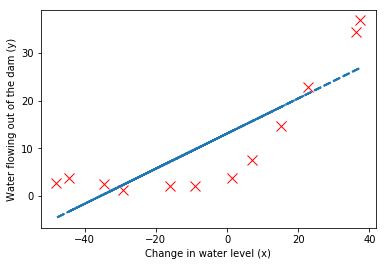

In [9]:
Lambda = 0
print (np.c_[np.ones((m, 1)), X].shape, y.shape)
theta = train_linear_reg(np.c_[np.ones((m, 1)), X], y, Lambda)

#  Plot fit over the data
plt.plot(X, y, 'rx', markersize= 10, linewidth= 1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
#plt.hold(True)
plt.plot(X, np.c_[np.ones((m, 1)), X]@theta, '--', linewidth=2)
plt.show()
#plt.hold(False)

## Part 5: Learning Curve for Linear Regression

In [10]:
def learning_curve(X, y, Xval, yval, Lambda):
#LEARNINGCURVE Generates the train and cross validation set errors needed
#to plot a learning curve
#   [error_train, error_val] = ...
#       LEARNINGCURVE(X, y, Xval, yval, lambda) returns the train and
#       cross validation set errors for a learning curve. In particular,
#       it returns two vectors of the same length - error_train and
#       error_val. Then, error_train(i) contains the training error for
#       i examples (and similarly for error_val(i)).
#

    # Number of training examples
    m = X.shape[0]

    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))

    for i in np.arange(m):
        j=i+1
        theta = train_linear_reg(X[:j,:], y[:j,:], Lambda)
        theta = theta.reshape((theta.size,1))
        #print (X[:j,:].shape, y[:j,:].shape, theta.shape)
        error_train[i], grad = linear_reg_cost_function(X[:j,:], y[:j,:], theta, 0)
        error_val[i], grad = linear_reg_cost_function(Xval, yval, theta, 0)
        #print (Xval.shape, yval.shape, m)
    
    return error_train, error_val


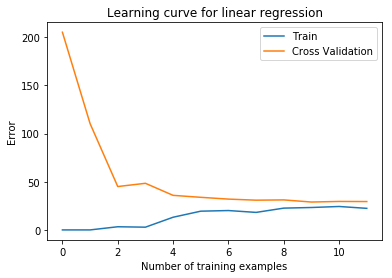

# Training Examples	Train Error	Cross Validation Error

(12, 1) (12, 1)
  	0		[  1.01769539e-18]	[ 205.12109571]

  	1		[  3.46657146e-09]	[ 110.30264058]

  	2		[ 3.28659505]	[ 45.01023145]

  	3		[ 2.84267769]	[ 48.36891058]

  	4		[ 13.15404881]	[ 35.86516475]

  	5		[ 19.44396251]	[ 33.82996177]

  	6		[ 20.09852166]	[ 31.97098583]

  	7		[ 18.1728587]	[ 30.86244626]

  	8		[ 22.60940542]	[ 31.13599772]

  	9		[ 23.26146159]	[ 28.93620747]

  	10		[ 24.31724959]	[ 29.55143162]

  	11		[ 22.3739065]	[ 29.43381813]



In [11]:
Lambda = 0
callb_count = 0# initialize count of learning iterations
callb_disp = False
error_train, error_val = learning_curve(np.c_[np.ones((m, 1)), X], y, np.c_[np.ones((Xval.shape[0], 1)), Xval], yval, Lambda)

plt.plot(np.arange(m), error_train, np.arange(m), error_val)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
#plt.axis([0, 13, 0, 150])
plt.show()

print('# Training Examples\tTrain Error\tCross Validation Error\n')
print (error_train.shape, error_val.shape)
for i in np.arange(m):
    print(f'  \t{i}\t\t{error_train[i]}\t{error_val[i]}\n')

## Part 6: Feature Mapping for Polynomial Regression 
One solution to this is to use polynomial regression. Now complete polyFeatures to map each example into its powers

In [12]:
def feature_normalize(X):
#FEATURENORMALIZE Normalizes the features in X 
#   FEATURENORMALIZE(X) returns a normalized version of X where
#   the mean value of each feature is 0 and the standard deviation
#   is 1. This is often a good preprocessing step to do when
#   working with learning algorithms.
    
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    
    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm = X_norm / sigma
    return X_norm, mu, sigma

In [13]:
def poly_features(X, p):
#POLYFEATURES Maps X (1D vector) into the p-th power
#   [X_poly] = POLYFEATURES(X, p) takes a data matrix X (size m x 1) and
#   maps each example into its polynomial features where
#   X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
    
    X_poly = X
    
    for i in np.arange(1,p): #=2:p
        j=i+1
        X_poly = np.c_[X_poly, X**j]
    return X_poly

In [14]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = poly_features(X, p)
X_poly, mu, sigma = feature_normalize(X_poly) # Normalize
X_poly = np.c_[np.ones((m, 1)), X_poly] # Add Ones

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = poly_features(Xtest, p)
X_poly_test = X_poly_test - mu #bsxfun(@minus, X_poly_test, mu);
X_poly_test = X_poly_test / sigma #bsxfun(@rdivide, X_poly_test, sigma);
X_poly_test = np.c_[np.ones((X_poly_test.shape[0], 1)), X_poly_test] # Add Ones

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = poly_features(Xval, p)
X_poly_val = X_poly_val - mu #bsxfun(@minus, X_poly_val, mu);
X_poly_val = X_poly_val / sigma #bsxfun(@rdivide, X_poly_val, sigma);
X_poly_val = np.c_[np.ones((X_poly_val.shape[0], 1)), X_poly_val] # Add Ones

print('Normalized Training Example 1:\n')
print(f'  {X_poly[0, :]}')

Normalized Training Example 1:

  [ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


## Part 7: Learning Curve for Polynomial Regression

Now, you will get to experiment with polynomial regression with multiple values of lambda. The code below runs polynomial regression with lambda = 0. You should try running the code with different values of
lambda to see how the fit and learning curve change.

In [15]:
def plot_fit(min_x, max_x, mu, sigma, theta, p):
# PLOTFIT Plots a learned polynomial regression fit over an existing figure.
#3Also works with linear regression.
#   PLOTFIT(min_x, max_x, mu, sigma, theta, p) plots the learned polynomial
#   fit with power p and feature normalization (mu, sigma).

    #We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x-15,max_x+25, 0.05) #x = (min_x - 15: 0.05 : max_x + 25)'

    # Map the X values 
    X_poly = poly_features(x, p)
    X_poly = X_poly - mu #bsxfun(@minus, X_poly, mu)
    X_poly = X_poly / sigma #bsxfun(@rdivide, X_poly, sigma)

    # Add ones
    X_poly = np.c_[np.ones((x.shape[0], 1)), X_poly]

    # Plot
    plt.plot(x, X_poly @ theta, '--', linewidth=2)


(12, 9) (12, 1)
Polynomial Regression (lambda = 0.01
# Training Examples	Train Error	Cross Validation Error

  0, [  1.67293932e-13], [ 138.84901847]
  1, [  3.22637390e-05], [ 143.53462541]
  2, [ 0.00044135], [ 11.02126965]
  3, [ 0.00275983], [ 7.81547141]
  4, [ 0.00220476], [ 7.92957965]
  5, [ 0.0217187], [ 10.17623743]
  6, [ 0.08323201], [ 5.35893052]
  7, [ 0.08784812], [ 4.82819588]
  8, [ 0.23857312], [ 7.34182755]
  9, [ 0.2370241], [ 7.45342583]
  10, [ 0.21738341], [ 7.77612245]
  11, [ 0.22155139], [ 16.92766647]


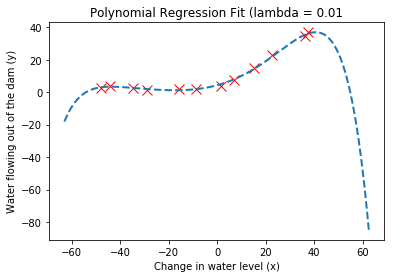

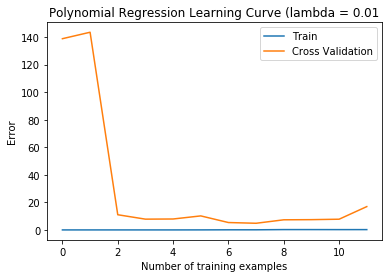

In [16]:
Lambda = 0.01
print(X_poly.shape, y.shape)
theta = train_linear_reg(X_poly, y, Lambda)

# Plot training data and fit
plt.figure(1)
plt.plot(X, y, 'rx', markersize=10, linewidth=1.5)
plot_fit(min(X), max(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title (f'Polynomial Regression Fit (lambda = {Lambda}')

plt.figure(2)
error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, Lambda)
plt.plot(np.arange(m), error_train, np.arange(m), error_val)

plt.title(f'Polynomial Regression Learning Curve (lambda = {Lambda}')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
#plt.axis([0 13 0 100])
plt.legend(('Train', 'Cross Validation'))

print(f'Polynomial Regression (lambda = {Lambda}')
print('# Training Examples\tTrain Error\tCross Validation Error\n');
for i in np.arange(m):
    print(f'  {i}, {error_train[i]}, {error_val[i]}')

## Part 8: Validation for Selecting Lambda 

In [22]:
def validation_curve(X, y, Xval, yval):
#function [lambda_vec, error_train, error_val] = validationCurve(X, y, Xval, yval)
#VALIDATIONCURVE Generate the train and validation errors needed to
#plot a validation curve that we can use to select lambda
#   [lambda_vec, error_train, error_val] = ...
#       VALIDATIONCURVE(X, y, Xval, yval) returns the train
#       and validation errors (in error_train, error_val)
#       for different values of lambda. You are given the training set (X,
#       y) and validation set (Xval, yval).

    # Selected values of lambda (you should not change this)
    lambda_vec = np.matrix('[0 0.001 0.003 0.01 0.03 0.1 0.3 1 3 10]').T.A
    error_train, error_val = np.zeros(lambda_vec.size), np.zeros(lambda_vec.size)
    for i in np.arange(lambda_vec.size):
        Lambda = lambda_vec[i]
        theta = train_linear_reg(X, y, Lambda)
        theta = theta.reshape((theta.size,1))
        # print(f'{theta.shape}\n{theta}')
        error_train[i], grad = linear_reg_cost_function(X, y, theta, 0) # note you test error without lambda
        error_val[i], grad = linear_reg_cost_function(Xval, yval, theta, 0) # note you test error without lambda
    return lambda_vec, error_train, error_val

lambda		Train Error	Validation Error

 [ 0.]	 0.04191498964866776	 21.16953492692328
 [ 0.001]	 0.11468881285734314	 10.14741971167643
 [ 0.003]	 0.17098130712650395	 16.29846453475378
 [ 0.01]	 0.22155138824497844	 16.92766646719461
 [ 0.03]	 0.28184136187376807	 12.83171283435356
 [ 0.1]	 0.45931702413902775	 7.587003954719044
 [ 0.3]	 0.9217780556126689	 4.636779068237207
 [ 1.]	 2.0762000345266722	 4.260601228097113
 [ 3.]	 4.901370103004489	 3.8229128766929588
 [ 10.]	 16.09227268911343	 9.94555420986328


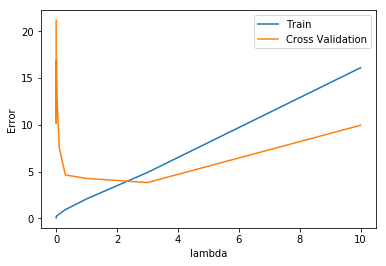

In [24]:
lambda_vec, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, lambda_vec, error_val);
plt.legend(('Train', 'Cross Validation'))
plt.xlabel('lambda')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error\n');
for i in np.arange(lambda_vec.size):
    print(f' {lambda_vec[i]}\t {error_train[i]}\t {error_val[i]}')